<h1 align="center"> Image Captioning</h1>

In this notebook you will teach a network to do image captioning.
![img](https://i.imgur.com/obITaMl.png)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

Cost of this notebook is **15 points**.

In [ ]:
# Please either download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.ipynb

### Data preprocessing

In [7]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 164 ms, sys: 796 ms, total: 960 ms
Wall time: 960 ms


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [8]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [9]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [10]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure
for caption in captions:
    for sent in caption:
        for word in sent:
            word_counts[word] += 1

In [11]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [14]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [15]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [16]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [20]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size) 
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, _ = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
        
        return logits        

In [41]:
network = CaptionNet(n_tokens)

In [22]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [23]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    criterion = nn.CrossEntropyLoss(ignore_index=pad_ix)
    loss = criterion(
        logits_for_next.view(-1, logits_for_next.shape[-1]),
        captions_ix_next.view(-1)
    )
    
    return loss

In [27]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [42]:
opt = torch.optim.AdamW(network.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)

# Training

* First implement the batch generator
* Than train the network as usual

In [29]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [30]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)
    

In [31]:
generate_batch(img_codes,captions,3)

(tensor([[0.1434, 0.1448, 0.1349,  ..., 0.1112, 0.1919, 0.1578],
         [1.1127, 0.4663, 0.3502,  ..., 0.2112, 0.2855, 0.0028],
         [0.0483, 0.5678, 0.6162,  ..., 0.7415, 0.7905, 0.7006]]),
 tensor([[   1,  336,   41,   24,  102,   14,   88,  394, 1590,  331,  163,  331,
            35,   45,   97,    2],
         [   1,   88, 1063,   17,  148,   18,   45,  500, 1359,    2,    3,    3,
             3,    3,    3,    3],
         [   1,   24,  106,   14,  588,   17,  246,   24,  865,   12,    2,    3,
             3,    3,    3,    3]]))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [43]:
batch_size = 50  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [45]:
from tqdm import tqdm

for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        opt.zero_grad()
        loss_t.backward()
        opt.step()
        
        train_loss += loss_t.item()
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches

    scheduler.step(val_loss)
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

100%|██████████| 50/50 [00:27<00:00,  1.82it/s]



Epoch: 0, train loss: 5.922899398803711, val loss: 4.957521152496338


100%|██████████| 50/50 [00:24<00:00,  2.04it/s]



Epoch: 1, train loss: 4.695048542022705, val loss: 4.527409458160401


100%|██████████| 50/50 [00:25<00:00,  1.98it/s]



Epoch: 2, train loss: 4.437391490936279, val loss: 4.325178050994873


100%|██████████| 50/50 [00:25<00:00,  1.95it/s]



Epoch: 3, train loss: 4.231090817451477, val loss: 4.183434057235718


100%|██████████| 50/50 [00:26<00:00,  1.91it/s]



Epoch: 4, train loss: 4.117991833686829, val loss: 4.145936107635498


100%|██████████| 50/50 [00:28<00:00,  1.74it/s]



Epoch: 5, train loss: 4.017995314598084, val loss: 4.028223085403442


100%|██████████| 50/50 [00:25<00:00,  1.96it/s]



Epoch: 6, train loss: 3.966813631057739, val loss: 3.8737671852111815


100%|██████████| 50/50 [00:25<00:00,  1.93it/s]



Epoch: 7, train loss: 3.832538890838623, val loss: 3.6305200099945067


100%|██████████| 50/50 [00:27<00:00,  1.84it/s]



Epoch: 8, train loss: 3.7314599084854128, val loss: 3.6344641208648683


100%|██████████| 50/50 [00:29<00:00,  1.71it/s]



Epoch: 9, train loss: 3.6923453998565674, val loss: 3.6923336505889894


100%|██████████| 50/50 [00:26<00:00,  1.88it/s]



Epoch: 10, train loss: 3.619679164886475, val loss: 3.517720651626587


100%|██████████| 50/50 [00:26<00:00,  1.90it/s]



Epoch: 11, train loss: 3.5781176233291627, val loss: 3.6092833518981933


100%|██████████| 50/50 [00:26<00:00,  1.92it/s]



Epoch: 12, train loss: 3.5229575777053834, val loss: 3.4465126037597655


100%|██████████| 50/50 [00:25<00:00,  1.95it/s]



Epoch: 13, train loss: 3.403363056182861, val loss: 3.4438498973846436


100%|██████████| 50/50 [00:25<00:00,  1.98it/s]



Epoch: 14, train loss: 3.421202292442322, val loss: 3.395123243331909


100%|██████████| 50/50 [00:26<00:00,  1.89it/s]



Epoch: 15, train loss: 3.374357876777649, val loss: 3.405837392807007


100%|██████████| 50/50 [00:25<00:00,  1.99it/s]



Epoch: 16, train loss: 3.3168943309783936, val loss: 3.3719736099243165


100%|██████████| 50/50 [00:24<00:00,  2.02it/s]



Epoch: 17, train loss: 3.296491198539734, val loss: 3.263716220855713


100%|██████████| 50/50 [00:25<00:00,  1.94it/s]



Epoch: 18, train loss: 3.2447396326065063, val loss: 3.222194719314575


100%|██████████| 50/50 [00:26<00:00,  1.90it/s]



Epoch: 19, train loss: 3.228697323799133, val loss: 3.1676400184631346


100%|██████████| 50/50 [00:23<00:00,  2.09it/s]



Epoch: 20, train loss: 3.2095432233810426, val loss: 3.2766889572143554


100%|██████████| 50/50 [00:26<00:00,  1.92it/s]



Epoch: 21, train loss: 3.1542291498184203, val loss: 3.114927339553833


100%|██████████| 50/50 [00:23<00:00,  2.13it/s]



Epoch: 22, train loss: 3.158070945739746, val loss: 3.168628692626953


100%|██████████| 50/50 [00:26<00:00,  1.87it/s]



Epoch: 23, train loss: 3.129917039871216, val loss: 3.287106990814209


100%|██████████| 50/50 [00:24<00:00,  2.05it/s]



Epoch: 24, train loss: 3.1352315092086793, val loss: 3.058320188522339


100%|██████████| 50/50 [00:24<00:00,  2.04it/s]



Epoch: 25, train loss: 3.0440503931045533, val loss: 3.194757318496704


100%|██████████| 50/50 [00:25<00:00,  1.98it/s]



Epoch: 26, train loss: 3.065948338508606, val loss: 3.1123109817504884


100%|██████████| 50/50 [00:25<00:00,  1.93it/s]



Epoch: 27, train loss: 3.0422786712646483, val loss: 3.0601696968078613


100%|██████████| 50/50 [00:24<00:00,  2.07it/s]



Epoch: 28, train loss: 3.0249063777923584, val loss: 3.2213881969451905


100%|██████████| 50/50 [00:28<00:00,  1.76it/s]



Epoch: 29, train loss: 3.0563168811798094, val loss: 3.091443681716919


100%|██████████| 50/50 [00:25<00:00,  1.94it/s]



Epoch: 30, train loss: 3.0145039319992066, val loss: 2.995985174179077


100%|██████████| 50/50 [00:27<00:00,  1.85it/s]



Epoch: 31, train loss: 3.033993639945984, val loss: 3.1225518226623534


100%|██████████| 50/50 [00:23<00:00,  2.10it/s]



Epoch: 32, train loss: 2.9593637943267823, val loss: 2.9779675006866455


100%|██████████| 50/50 [00:27<00:00,  1.81it/s]



Epoch: 33, train loss: 2.979627556800842, val loss: 3.1045183658599855


100%|██████████| 50/50 [00:26<00:00,  1.89it/s]



Epoch: 34, train loss: 2.9988637924194337, val loss: 2.9864574432373048


100%|██████████| 50/50 [00:26<00:00,  1.89it/s]



Epoch: 35, train loss: 2.9309414768218995, val loss: 2.986591339111328


100%|██████████| 50/50 [00:24<00:00,  2.01it/s]



Epoch: 36, train loss: 2.9159993028640745, val loss: 2.937453365325928


100%|██████████| 50/50 [00:25<00:00,  1.93it/s]



Epoch: 37, train loss: 2.922397117614746, val loss: 2.962109327316284


100%|██████████| 50/50 [00:25<00:00,  1.99it/s]



Epoch: 38, train loss: 2.969677543640137, val loss: 2.977142333984375


100%|██████████| 50/50 [00:24<00:00,  2.00it/s]



Epoch: 39, train loss: 2.8973392724990843, val loss: 2.995794439315796


100%|██████████| 50/50 [00:29<00:00,  1.68it/s]



Epoch: 40, train loss: 2.9502774572372434, val loss: 2.922866868972778


100%|██████████| 50/50 [00:28<00:00,  1.77it/s]



Epoch: 41, train loss: 2.8826598072052003, val loss: 2.9120090007781982


100%|██████████| 50/50 [00:28<00:00,  1.78it/s]



Epoch: 42, train loss: 2.9393056058883666, val loss: 2.999984788894653


100%|██████████| 50/50 [00:28<00:00,  1.74it/s]



Epoch: 43, train loss: 2.9015625286102296, val loss: 2.8574320316314696


100%|██████████| 50/50 [00:30<00:00,  1.66it/s]



Epoch: 44, train loss: 2.9001532363891602, val loss: 2.9397676467895506


100%|██████████| 50/50 [00:29<00:00,  1.67it/s]



Epoch: 45, train loss: 2.896074948310852, val loss: 2.839915132522583


100%|██████████| 50/50 [00:29<00:00,  1.68it/s]



Epoch: 46, train loss: 2.899133462905884, val loss: 2.7235676765441896


100%|██████████| 50/50 [00:31<00:00,  1.58it/s]



Epoch: 47, train loss: 2.86910804271698, val loss: 2.819902515411377


100%|██████████| 50/50 [00:28<00:00,  1.75it/s]



Epoch: 48, train loss: 2.8684281730651855, val loss: 2.9203467845916746


100%|██████████| 50/50 [00:29<00:00,  1.71it/s]



Epoch: 49, train loss: 2.8373894691467285, val loss: 2.9112547874450683


100%|██████████| 50/50 [00:28<00:00,  1.75it/s]



Epoch: 50, train loss: 2.7939125442504884, val loss: 2.8921971321105957


100%|██████████| 50/50 [00:28<00:00,  1.77it/s]



Epoch: 51, train loss: 2.828547463417053, val loss: 2.920703172683716


100%|██████████| 50/50 [00:29<00:00,  1.69it/s]



Epoch: 52, train loss: 2.8490394258499148, val loss: 2.752479410171509


100%|██████████| 50/50 [00:31<00:00,  1.61it/s]



Epoch: 53, train loss: 2.806423850059509, val loss: 2.906770038604736


100%|██████████| 50/50 [00:32<00:00,  1.55it/s]



Epoch: 54, train loss: 2.795163493156433, val loss: 2.86061110496521


100%|██████████| 50/50 [00:30<00:00,  1.65it/s]



Epoch: 55, train loss: 2.8082183456420897, val loss: 2.821566915512085


100%|██████████| 50/50 [00:29<00:00,  1.70it/s]



Epoch: 56, train loss: 2.791684422492981, val loss: 2.786950206756592


100%|██████████| 50/50 [00:30<00:00,  1.64it/s]



Epoch: 57, train loss: 2.7891248989105226, val loss: 2.807221221923828


100%|██████████| 50/50 [00:29<00:00,  1.68it/s]



Epoch: 58, train loss: 2.772971024513245, val loss: 2.913419246673584


100%|██████████| 50/50 [00:29<00:00,  1.67it/s]



Epoch: 59, train loss: 2.7856242942810057, val loss: 2.861458253860474


100%|██████████| 50/50 [00:29<00:00,  1.69it/s]



Epoch: 60, train loss: 2.736581354141235, val loss: 2.7700171947479246


100%|██████████| 50/50 [00:30<00:00,  1.66it/s]



Epoch: 61, train loss: 2.7662694883346557, val loss: 2.741323947906494


100%|██████████| 50/50 [00:31<00:00,  1.58it/s]



Epoch: 62, train loss: 2.7888180923461916, val loss: 2.7275274276733397


100%|██████████| 50/50 [00:31<00:00,  1.61it/s]



Epoch: 63, train loss: 2.765567045211792, val loss: 2.7998497009277346


100%|██████████| 50/50 [00:31<00:00,  1.60it/s]



Epoch: 64, train loss: 2.7530293035507203, val loss: 2.945514965057373


100%|██████████| 50/50 [00:28<00:00,  1.73it/s]



Epoch: 65, train loss: 2.741650815010071, val loss: 2.820565366744995


100%|██████████| 50/50 [00:30<00:00,  1.62it/s]



Epoch: 66, train loss: 2.763322629928589, val loss: 2.81707124710083


100%|██████████| 50/50 [00:29<00:00,  1.71it/s]



Epoch: 67, train loss: 2.753960580825806, val loss: 2.736153507232666


100%|██████████| 50/50 [00:31<00:00,  1.57it/s]



Epoch: 68, train loss: 2.7670593070983887, val loss: 2.7983164310455324


100%|██████████| 50/50 [00:29<00:00,  1.70it/s]



Epoch: 69, train loss: 2.7695820713043213, val loss: 2.7841784000396728


100%|██████████| 50/50 [00:30<00:00,  1.63it/s]



Epoch: 70, train loss: 2.7641076326370237, val loss: 2.7795951843261717


100%|██████████| 50/50 [00:31<00:00,  1.61it/s]



Epoch: 71, train loss: 2.714945340156555, val loss: 2.804078960418701


100%|██████████| 50/50 [00:30<00:00,  1.67it/s]



Epoch: 72, train loss: 2.73573673248291, val loss: 2.7278626441955565


100%|██████████| 50/50 [00:28<00:00,  1.76it/s]



Epoch: 73, train loss: 2.733688025474548, val loss: 2.77675199508667


100%|██████████| 50/50 [00:28<00:00,  1.73it/s]



Epoch: 74, train loss: 2.7150418949127197, val loss: 2.805745077133179


100%|██████████| 50/50 [00:29<00:00,  1.67it/s]



Epoch: 75, train loss: 2.750190644264221, val loss: 2.6977377414703367


100%|██████████| 50/50 [00:29<00:00,  1.67it/s]



Epoch: 76, train loss: 2.776357078552246, val loss: 2.785699892044067


100%|██████████| 50/50 [00:29<00:00,  1.70it/s]



Epoch: 77, train loss: 2.777606739997864, val loss: 2.778565454483032


100%|██████████| 50/50 [00:29<00:00,  1.69it/s]



Epoch: 78, train loss: 2.742709922790527, val loss: 2.8025846004486086


100%|██████████| 50/50 [00:28<00:00,  1.74it/s]



Epoch: 79, train loss: 2.741889977455139, val loss: 2.815876913070679


100%|██████████| 50/50 [00:28<00:00,  1.78it/s]



Epoch: 80, train loss: 2.8066510343551636, val loss: 2.7222479820251464


100%|██████████| 50/50 [00:30<00:00,  1.64it/s]



Epoch: 81, train loss: 2.781801562309265, val loss: 2.76476411819458


100%|██████████| 50/50 [00:29<00:00,  1.69it/s]



Epoch: 82, train loss: 2.762245044708252, val loss: 2.7236066818237306


100%|██████████| 50/50 [00:30<00:00,  1.64it/s]



Epoch: 83, train loss: 2.7295005464553834, val loss: 2.686452102661133


100%|██████████| 50/50 [00:28<00:00,  1.76it/s]



Epoch: 84, train loss: 2.7266956424713134, val loss: 2.727967882156372


100%|██████████| 50/50 [00:29<00:00,  1.71it/s]



Epoch: 85, train loss: 2.7199250650405884, val loss: 2.752557945251465


100%|██████████| 50/50 [00:29<00:00,  1.70it/s]



Epoch: 86, train loss: 2.7302335786819456, val loss: 2.7811638832092287


100%|██████████| 50/50 [00:29<00:00,  1.71it/s]



Epoch: 87, train loss: 2.7489500141143797, val loss: 2.8173853874206545


100%|██████████| 50/50 [00:29<00:00,  1.68it/s]



Epoch: 88, train loss: 2.747660503387451, val loss: 2.8134315490722654


100%|██████████| 50/50 [00:30<00:00,  1.62it/s]



Epoch: 89, train loss: 2.747774348258972, val loss: 2.7079256534576417


100%|██████████| 50/50 [00:28<00:00,  1.74it/s]



Epoch: 90, train loss: 2.719612703323364, val loss: 2.7321056365966796


100%|██████████| 50/50 [00:28<00:00,  1.75it/s]



Epoch: 91, train loss: 2.744655604362488, val loss: 2.84399209022522


100%|██████████| 50/50 [00:27<00:00,  1.84it/s]



Epoch: 92, train loss: 2.732647404670715, val loss: 2.758492851257324


100%|██████████| 50/50 [00:28<00:00,  1.73it/s]



Epoch: 93, train loss: 2.721266689300537, val loss: 2.7780348777771


100%|██████████| 50/50 [00:30<00:00,  1.66it/s]



Epoch: 94, train loss: 2.738391499519348, val loss: 2.785002851486206


100%|██████████| 50/50 [00:28<00:00,  1.76it/s]



Epoch: 95, train loss: 2.7532058477401735, val loss: 2.8363268852233885


100%|██████████| 50/50 [00:29<00:00,  1.67it/s]



Epoch: 96, train loss: 2.6972897624969483, val loss: 2.8071385860443114


100%|██████████| 50/50 [00:29<00:00,  1.67it/s]



Epoch: 97, train loss: 2.760823531150818, val loss: 2.798714017868042


100%|██████████| 50/50 [00:30<00:00,  1.65it/s]



Epoch: 98, train loss: 2.742405471801758, val loss: 2.78832893371582


100%|██████████| 50/50 [00:30<00:00,  1.64it/s]



Epoch: 99, train loss: 2.7251065492630007, val loss: 2.768418216705322
Finished!


### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [46]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [35]:
def generate_caption(image, caption_prefix=("#START#",), 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
    return caption_prefix

In [47]:
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

--2022-06-21 07:01:03--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2022-06-21 07:01:03--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53.45K  --.-KB/s    in 0.004s  

2022-06-21 07:01:03 (14.4 MB/s) - ‘data/img.jpg’ sa

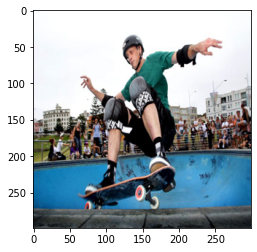

In [48]:
plt.imshow(img)

In [49]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man riding a skateboard on a skateboard .
a man on a skateboard doing a trick on a skateboard .
a man riding a skateboard on a skateboard .
a man riding a skateboard on a skateboard .
a man riding a skateboard on a skateboard .
a man riding a skateboard on a skateboard .
a man is doing a trick on a skateboard .
a man riding a skateboard on a skateboard
a man is doing a trick on a skateboard .
a man riding a skateboard on a skateboard .


--2022-06-21 07:20:54--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 162.159.135.42
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2022-06-21 07:20:54--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 104.37K   268KB/s    in 0.4s    

2022-06-21 07:20:55 (268 KB/s) - ‘data/img.jpg’ saved [106870/106870]



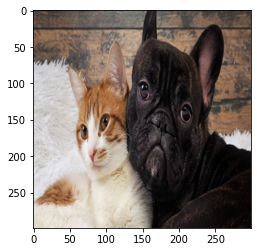

a cat laying on a bed with a red teddy bear .
a cat is sitting on a chair next to a computer .
a cat laying on a bed with a teddy bear .
a cat laying on a bed with a teddy bear .
a cat is sitting on a chair with a teddy bear .
a cat is sitting on a chair with a laptop .
a cat is sitting on a chair next to a laptop .
a cat is sitting on a chair next to a window .
a cat laying on a bed with a laptop .
a cat is sitting on a table with a book .


In [68]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.

* Seriously, that's a part of the assignment. Go get at least 10 pictures for captioning
* Make sure it works okay on __simple__ images before going to something more complex
* Your pictures must feature both successful and failed captioning. Get creative :)
* Use photos, not animation/3d/drawings, unless you want to re-train CNN network on anime
* Mind the aspect ratio.

In [ ]:
# apply your network on images you've found
#
#

In [69]:
def generate_caption_by_url(url):
    !wget -q $url -O data/img.jpg
    img = plt.imread('data/img.jpg')
    img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

    plt.imshow(img)
    plt.show()

    for i in range(10):
        print(' '.join(generate_caption(img, t=5.)[1:-1]))

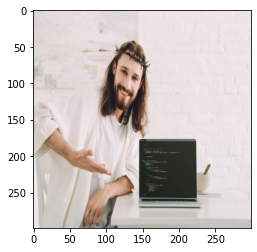

a man in a suit and a woman playing a game .
a man and woman are playing a video game .
a man is holding a cell phone while another man is holding a cell phone .
a man is sitting at a table with a laptop computer .
a man sitting on a couch while holding a laptop .
a man in a suit and tie is holding a cell phone .
a man in a suit and a woman playing a game .
a man is sitting at a table with a laptop computer .
a man is holding a cell phone while a man in the background .
a man in a chair holding a cell phone .


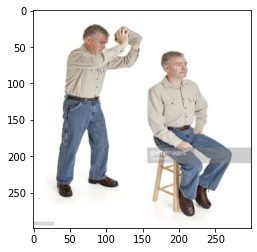

a man and a woman wearing a suit and tie .
a man in a suit and tie is standing on a bench .
a man and a woman in a suit and tie .
a man and woman standing in a room with a man .
a man is standing in a suit and tie .
a man and a woman standing on a bench .
a man in a suit and tie is holding a dog .
a man in a suit and tie is standing in the snow .
a man in a suit and tie is holding a dog .
a man in a suit and tie is holding a dog .


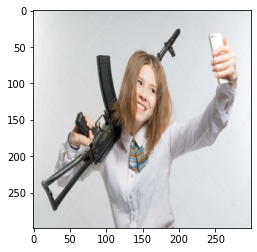

a man with a tie and a tie in a blue shirt and a black tie .
a woman is holding a red teddy bear .
a man is holding a cell phone to his ear .
a woman holding a red and white plate
a man in a red shirt is holding a cell phone .
a man holding a cell phone while holding a cell phone .
a man in a red shirt is holding a cell phone .
a man in a red shirt is holding a cell phone .
a man in a red shirt is holding a cell phone .
a man is holding a cell phone to his ear .


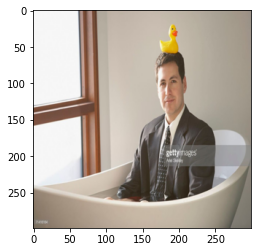

a man in a black shirt is sitting on a skateboard .
a man is sitting on a skateboard in front of a building .
a man in a suit and a black shirt is sitting on a bench .
a man is sitting on a bench in a park .
a man sitting on a bench in front of a building .
a man standing next to a dog in a room .
a man is standing next to a car .
a man in a black shirt is sitting on a bench .
a man in a black shirt is sitting on a bench .
a man with a black and white dog in his hand .


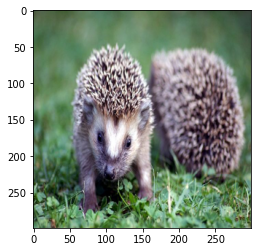

a cake with a bunch of different types of food .
a person holding a sandwich and a banana .
a close up of a cake with a #UNK# on it .
a cake with a variety of scissors and a cup of coffee .
a cake with a bunch of bananas on it .
a close up of a cake with a #UNK# on it .
a close up of a cake with a knife .
a bunch of different types of food .
a person holding a sandwich and a drink .
a close up of a cake with a cake on it


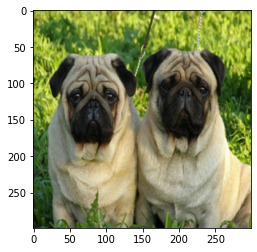

a dog is sitting on a bench near a building .
a dog is sitting on a bench in the middle of a park .
a dog is sitting on a bench .
a dog is sitting on a bench in the middle of a park .
a dog is sitting on a bench .
a dog is sitting on a bench next to a tree .
a dog is sitting on a bench in a park .
a dog is sitting on a bench in the middle of a park .
a dog is sitting on a bench in the middle of a park .
a dog is sitting on a bench with a dog on a leash .


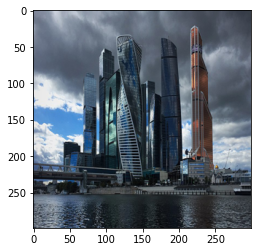

a large boat in the water with a large body of water .
a group of people are flying kites in the water .
a group of people flying kites in the sky .
a group of people standing on a beach with a kite .
a large boat is on the beach with a large body of water .
a large group of people flying kites in the sky .
a large group of people sitting on a beach .
a group of people on a beach with a kite in the background .
a group of people on a beach with a kite .
a group of people flying kites in the sky .


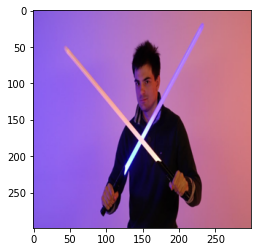

a man holding a bat in a room .
a woman holding a tennis racquet on a court .
a woman holding a bat in a blue shirt and a black shirt .
a woman is holding a bat in his hand .
a woman holding a tennis racket in a blue sky .
a man holding a tennis racket in a room .
a woman holding a cell phone in his hand .
a woman holding a bat in a room .
a woman holding a baseball bat in a field .
a man holding a baseball bat in a field .


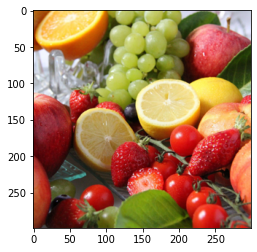

a bowl of fruit and vegetables on a table .
a bowl of fruit and vegetables on a table .
a bunch of vegetables and vegetables on a table .
a bowl of food with a bowl of fruit .
a bowl of fruit and vegetables on a table .
a bowl of fruit and vegetables on a table .
a bowl of fruit and vegetables on a table .
a bowl of fruit , carrots , and vegetables on a table .
a bowl of fruit and vegetables on a table .
a bowl of fruit and vegetables on a table .


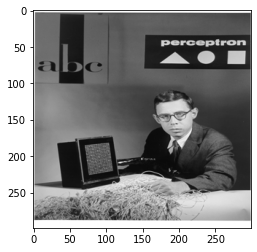

a man sitting on a couch with a laptop computer .
a man is sitting on a chair with a laptop .
a man in a chair with a laptop and a laptop .
a man and a woman sitting on a couch .
a man and a woman sitting on a couch with a laptop .
a man and a woman sitting on a couch .
a man sitting on a couch using a laptop computer .
a man sitting on a couch using a laptop computer .
a man is sitting on a couch using a laptop computer .
a man sitting on a couch with a laptop computer .


In [70]:
urls = (
    'https://highload.today/wp-content/uploads/2021/06/Depositphotos_216200912_s-2019.jpg',
    'https://i.pinimg.com/564x/51/07/94/510794300a9c77bc108084fe2110c1d6.jpg',
    'https://cdn.fishki.net/upload/post/2017/07/07/2331579/tn/322e020167ed98f8b23f856b5912e31f.jpg',
    'https://vobar.ru/uploads/blog_3/blog-Fiv9SWGWlT.jpg',
    'https://aif-s3.aif.ru/images/017/228/1cf7688469151c3b4d943b257a2e6194.jpg',
    'https://www.ekzotika.com/ekzotika_img/dogs/56.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/thumb/1/1c/Moscow-city%2C_riverfront_view%2831631549126%29.jpg/800px-Moscow-city%2C_riverfront_view%2831631549126%29.jpg',
    'https://i.ytimg.com/vi/cflEHI5EjAc/maxresdefault.jpg',
    'https://cdnn1.inosmi.ru/img/25108/38/251083893_320:0:1600:1280_1920x0_80_0_0_0a5f0a2a45b7e69beda31e583ca66569.jpg',
    'https://tripleampersand.org/wp-content/uploads/2020/04/1.png'
)

for url in urls:
    generate_caption_by_url(url)

Good hunting!
![img](https://cs7.pikabu.ru/images/big_size_comm_an/2018-09_3/1536865148163644198.gif)